# Home Loan Data Analysis


### Problem statement:

For a safe and secure lending experience, it's important to analyze the past data. In this project, you have to build a deep learning model to predict the chance of default for future loans using historical data. As you will see, this dataset is highly imbalanced and includes a lot of features that make this problem more challenging.

### Objective: 
Create a model that predicts whether or not an applicant will be able to repay a loan using historical data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LayerNormalization, Add, Multiply, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall, AUC, Precision
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, recall_score, ConfusionMatrixDisplay, roc_curve



In [3]:
df = pd.read_csv('loan_data.csv')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [5]:
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
missing = missing.to_frame(name='missing')
missing['percent'] = missing['missing'] / df.shape[0] * 100
missing = missing.sort_values(by='percent', ascending=False)
missing = missing[missing['percent'] > 0]
missing = missing.reset_index()
missing.columns = ['column', 'missing', 'percent']
missing.head(20)

,column,missing,percent
0,COMMONAREA_MEDI,214865,69.872297
1,COMMONAREA_MODE,214865,69.872297
2,COMMONAREA_AVG,214865,69.872297
3,NONLIVINGAPARTMENTS_MODE,213514,69.432963
4,NONLIVINGAPARTMENTS_AVG,213514,69.432963
5,NONLIVINGAPARTMENTS_MEDI,213514,69.432963
6,FONDKAPREMONT_MODE,210295,68.386172
7,LIVINGAPARTMENTS_MODE,210199,68.354953
8,LIVINGAPARTMENTS_AVG,210199,68.354953
9,LIVINGAPARTMENTS_MEDI,210199,68.354953


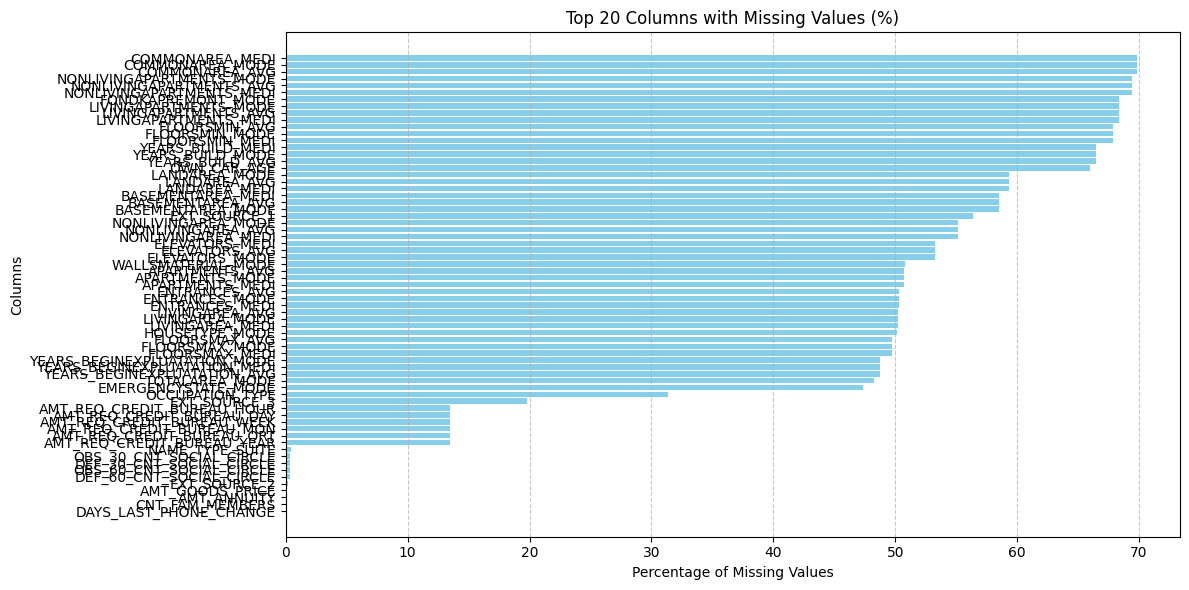

In [6]:
plt.figure(figsize=(12, 6))
plt.barh(missing['column'][::-1], missing['percent'][::-1], color='skyblue')
plt.title('Top 20 Columns with Missing Values (%)')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Columns')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

There are a lot of culumns that have more than 40 percent missing values. So I decided to remove thos columns.

In [7]:
columns_to_drop = missing[missing['percent'] > 40]['column'].tolist()
df = df.drop(columns=columns_to_drop)

print(f"Dropped {len(columns_to_drop)} columns with >40% missing values.")


Dropped 49 columns with >40% missing values.


In [8]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
missing.tail(20)

,column,missing,percent
47,TOTALAREA_MODE,148431,48.268517
48,EMERGENCYSTATE_MODE,145755,47.398304
49,OCCUPATION_TYPE,96391,31.345545
50,EXT_SOURCE_3,60965,19.825307
51,AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.501631
52,AMT_REQ_CREDIT_BUREAU_DAY,41519,13.501631
53,AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.501631
54,AMT_REQ_CREDIT_BUREAU_MON,41519,13.501631
55,AMT_REQ_CREDIT_BUREAU_QRT,41519,13.501631
56,AMT_REQ_CREDIT_BUREAU_YEAR,41519,13.501631


For the ramaining columns with missing values, replacing the mean for numerical and mode for categorical values.

In [10]:
columns_fill = missing[(missing['percent'] < 40) & (missing['percent'] > 0)]['column'].tolist()


for col in columns_fill:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

print(f"Filled missing values with mean (numerical) and mode (categorical) for {len(columns_fill)} columns.")


Filled missing values with mean (numerical) and mode (categorical) for 18 columns.


In [11]:
print(df.isnull().sum().sum())

0


In [12]:
duplicated = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicated}")


Number of duplicate rows: 0


There is no duplicates in our dataset.

TARGET Distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64

 Percentage Distribution:
TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64


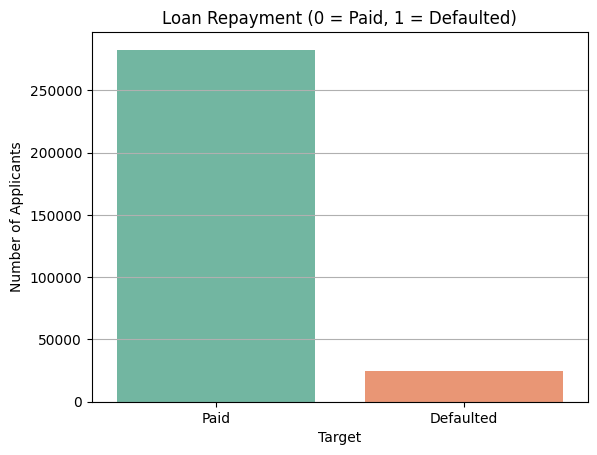

In [13]:
target = df['TARGET'].value_counts()
target_percent = df['TARGET'].value_counts(normalize=True) * 100

print("TARGET Distribution:")
print(target)
print("\n Percentage Distribution:")
print(target_percent)

sns.countplot(data=df, x='TARGET', hue='TARGET', palette='Set2', legend=False)
plt.title('Loan Repayment (0 = Paid, 1 = Defaulted)')
plt.xlabel('Target')
plt.ylabel('Number of Applicants')
plt.xticks([0, 1], ['Paid', 'Defaulted'])
plt.grid(axis='y')
plt.show()


There are 282686 (~92%) paid aplicatnts in our dataset and 24825 (~8%) defaulted applicants so our dataset is imbalanced. 

In [14]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {y_train.value_counts().to_dict()}")
print(f"After SMOTE: {y_train_resampled.value_counts().to_dict()}")

Before SMOTE: {0: 226148, 1: 19860}
After SMOTE: {0: 226148, 1: 226148}


To find the most correlated columns with TARGET including numerical and categorical, I made a copy and combined X and y and ploted the top 15 correlation. 

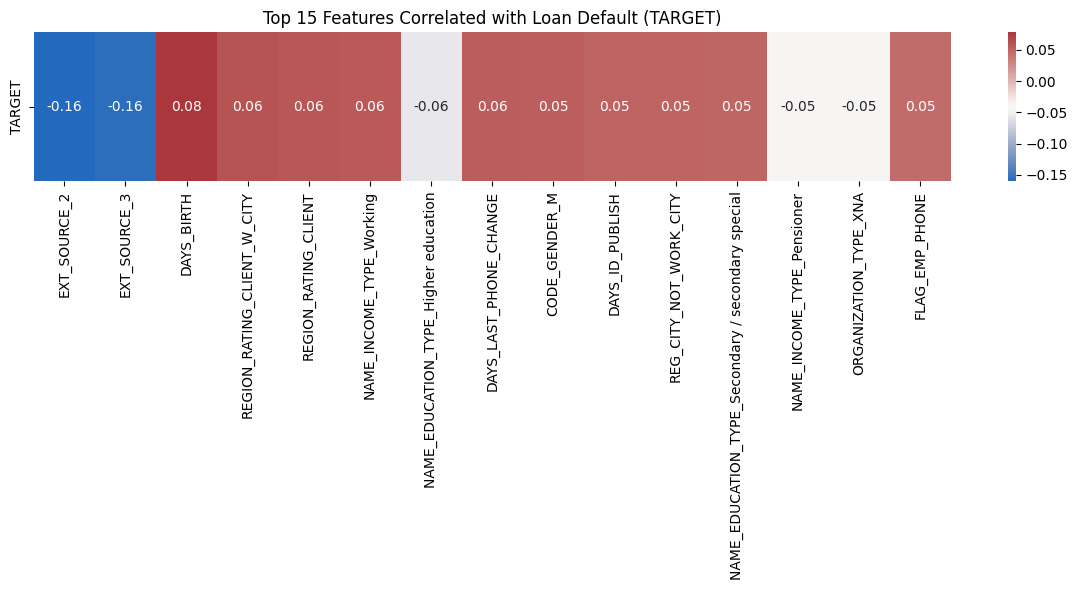

In [15]:
X_with_target = X.copy()
X_with_target['TARGET'] = y

correlations = X_with_target.corr(numeric_only=True)['TARGET'].sort_values(key=abs, ascending=False)
top_corr = correlations[1:16] 

plt.figure(figsize=(12, 6))
sns.heatmap(top_corr.to_frame().T, annot=True, cmap='vlag', fmt=".2f", cbar=True)
plt.title('Top 15 Features Correlated with Loan Default (TARGET)')
plt.tight_layout()
plt.show()

In [ ]:
df['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

The correlation heatmap shows the top 15 features correlated with loan default (TARGET). 
The features 'EXT_SOURCE_2' and 'EXT_SOURCE_3' have a strong negative correlation. This suggests that higher applicant's Normalized score the lower the chance that the applicant would default. 
On the other hand, 'DAYS_BIRTH' is the highest positive correlation, suggesting the younger the applicant is more likely to default, since the values in this column are negative so the older the applicant is the smaller is the number. 

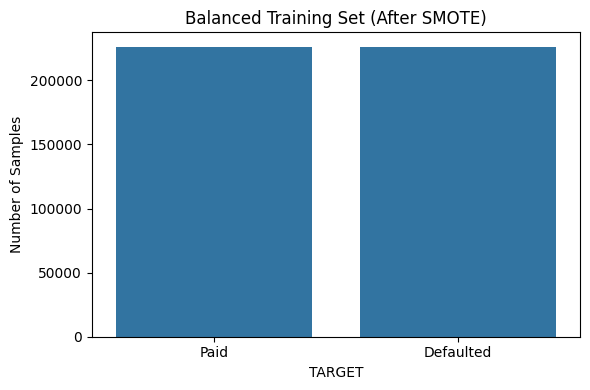

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_resampled)
plt.title('Balanced Training Set (After SMOTE)')
plt.xlabel('TARGET')
plt.ylabel('Number of Samples')
plt.xticks([0, 1], ['Paid', 'Defaulted'])
plt.tight_layout()
plt.show()

### Train the model Neural Network 

In [ ]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid') 
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall()])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_balanced = model.fit(
    X_train_resampled, y_train_resampled,
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1,
)

/Users/pariaep/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8423 - loss: 0.3689 - recall: 0.7526 - val_accuracy: 0.9602 - val_loss: 0.0783 - val_recall: 0.9602
Epoch 2/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9241 - loss: 0.2168 - recall: 0.8150 - val_accuracy: 0.9552 - val_loss: 0.0798 - val_recall: 0.9552
Epoch 3/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9262 - loss: 0.2100 - recall: 0.8171 - val_accuracy: 0.9563 - val_loss: 0.0738 - val_recall: 0.9563
Epoch 4/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9273 - loss: 0.2073 - recall: 0.8193 - val_accuracy: 0.9594 - val_loss: 0.0698 - val_recall: 0.9594
Epoch 5/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9291 - loss: 0.2031 - recall: 0.8223 - val_accuracy: 0.9615 - val_loss: 0.0681 - val_recall: 0.9615
Epoch 6/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9286 - loss: 0.2025 - recall: 0.8244 - val_accuracy: 0.9582 - val_loss: 0.0726 - val_recall:

In [ ]:
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.2).astype(int)
cm = confusion_matrix(y_test, y_pred)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(cm)

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))


1922/1922 ━━━━━━━━━━━━━━━━━━━━ 1s 374us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92     56538
           1       0.22      0.31      0.26      4965

    accuracy                           0.86     61503
   macro avg       0.58      0.61      0.59     61503
weighted avg       0.88      0.86      0.87     61503

Confusion Matrix:
[[51264  5274]
 [ 3440  1525]]
ROC AUC Score: 0.73252383401772


The model now catches 31% of actual defaulters.
False positives (paid but flagged as default) are relatively low (5k vs. 51k correct).
Precision for defaulters is 22% — not great, but acceptable given recall gains.
ROC AUC > 0.73 indicates the model is genuinely learning meaningful patterns.

### Train with AutoEncoder- Classification 

In [ ]:

input_dim = X_train_resampled.shape[1]
encoding_dim = 64 


input_layer = Input(shape=(input_dim,))

encoded = Dense(256, activation='relu')(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)


decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)


encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train_resampled, X_train_resampled,
                epochs=20,
                batch_size=256,
                validation_split=0.2,
                verbose=1)


Epoch 1/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3616 - val_loss: 0.3248
Epoch 2/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3677 - val_loss: 0.3244
Epoch 3/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3426 - val_loss: 0.3216
Epoch 4/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3246 - val_loss: 0.2555
Epoch 5/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2838 - val_loss: 0.2528
Epoch 6/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2718 - val_loss: 0.2523
Epoch 7/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2808 - val_loss: 0.2519
Epoch 8/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2905 - val_loss: 0.2515
Epoch 9/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2750 - val_loss: 0.2513
Epoch 10/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2841 - val_loss: 0.2511
Epoch 11/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2732 - val_loss: 0.2511
Epoch 12/20
1414/1414 ━━━━━━━━

In [ ]:
encoder = Model(inputs=input_layer, outputs=encoded)

X_train_encoded = encoder.predict(X_train_resampled)
X_test_encoded = encoder.predict(X_test)

classifier = Sequential([
    Dense(64, activation='relu', input_shape=(encoding_dim,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

classifier.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(name='recall'), AUC(name='auc')]
)

history_autoencoder = classifier.fit(
    X_train_encoded, y_train_resampled,
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)


14135/14135 ━━━━━━━━━━━━━━━━━━━━ 4s 309us/step
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 1s 313us/step
Epoch 1/20


/Users/pariaep/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1414/1414 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7282 - auc: 0.7657 - loss: 0.5552 - recall: 0.5070 - val_accuracy: 0.7765 - val_auc: 0.0000e+00 - val_loss: 0.3840 - val_recall: 0.7765
Epoch 2/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 1s 949us/step - accuracy: 0.8351 - auc: 0.8804 - loss: 0.3942 - recall: 0.6592 - val_accuracy: 0.7608 - val_auc: 0.0000e+00 - val_loss: 0.4233 - val_recall: 0.7608
Epoch 3/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step - accuracy: 0.8410 - auc: 0.8838 - loss: 0.3874 - recall: 0.6734 - val_accuracy: 0.8279 - val_auc: 0.0000e+00 - val_loss: 0.2797 - val_recall: 0.8279
Epoch 4/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 1s 964us/step - accuracy: 0.8487 - auc: 0.8897 - loss: 0.3705 - recall: 0.6802 - val_accuracy: 0.8086 - val_auc: 0.0000e+00 - val_loss: 0.3256 - val_recall: 0.8086
Epoch 5/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step - accuracy: 0.8473 - auc: 0.8882 - loss: 0.3749 - recall: 0.6783 - val_accuracy: 0.7350 - val_auc: 0.0000e+00 - val_loss: 0.4219 - va

In [ ]:
# Predict and evaluate
y_pred_prob = classifier.predict(X_test_encoded).ravel()
y_pred = (y_pred_prob > 0.2).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))


1922/1922 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.47      0.63     56538
           1       0.10      0.66      0.17      4965

    accuracy                           0.49     61503
   macro avg       0.52      0.57      0.40     61503
weighted avg       0.87      0.49      0.59     61503

Confusion Matrix:
[[26758 29780]
 [ 1677  3288]]
ROC AUC: 0.6068081776011977


We got 66% of actual defaulters (recall) — that's huge. model is highly sensitive to defaulted cases.
Massive drop in precision (0.10 for defaulters)
29780 false positives — meaning many reliable payers are misclassified.
Overall accuracy dropped to 52%, because so many 'Paid' cases are incorrectly flagged.

### Train Imbalanced Data

In [ ]:
model_imbalanced = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid') 
])


model_imbalanced.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall()])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_imbalanced = model_imbalanced.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1,
)

/Users/pariaep/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7686 - loss: 0.5492 - recall_1: 0.2118 - val_accuracy: 0.9177 - val_loss: 0.2655 - val_recall_1: 0.0000e+00
Epoch 2/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9169 - loss: 0.2765 - recall_1: 0.0107 - val_accuracy: 0.9177 - val_loss: 0.2605 - val_recall_1: 0.0000e+00
Epoch 3/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9192 - loss: 0.2632 - recall_1: 0.0093 - val_accuracy: 0.9177 - val_loss: 0.2573 - val_recall_1: 0.0000e+00
Epoch 4/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9184 - loss: 0.2612 - recall_1: 0.0069 - val_accuracy: 0.9177 - val_loss: 0.2561 - val_recall_1: 0.0000e+00
Epoch 5/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9188 - loss: 0.2579 - recall_1: 0.0075 - val_accuracy: 0.9177 - val_loss: 0.2552 - val_recall_1: 0.0000e+00
Epoch 6/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9191 - loss: 0.2545 - recall_1: 0.0081 - val_accuracy: 0.9177 - 

In [ ]:
y_pred_prob_imb = model_imbalanced.predict(X_test).ravel()
y_pred_imb = (y_pred_prob_imb > 0.2).astype(int)
cm = confusion_matrix(y_test, y_pred_imb)

print("Classification Report:")
print(classification_report(y_test, y_pred_imb))

print("Confusion Matrix:")
print(cm)

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_imb))

1922/1922 ━━━━━━━━━━━━━━━━━━━━ 1s 377us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     56538
           1       0.28      0.26      0.27      4965

    accuracy                           0.89     61503
   macro avg       0.61      0.60      0.60     61503
weighted avg       0.88      0.89      0.88     61503

Confusion Matrix:
[[53238  3300]
 [ 3676  1289]]
ROC AUC Score: 0.7462650720311558


Great ROC AUC (0.7462)
Recall for class 1 (defaulters) = 26%: catching more than 1 in 4 defaulters, without SMOTE!
High accuracy and balanced F1-scores, even with imbalanced training.
3676 false positives (paid predicted as defaulted) — reasonable in financial use cases.
Precision for class 1 is ~28%, meaning most default predictions are still false alarms — but better than random.

### Train Balanced Data with GRN 

In [ ]:
def GRN(units, input_layer, context_layer=None):
    x = Dense(units)(input_layer)
    x = Activation('elu')(x)

    if context_layer is not None:
        context = Dense(units)(context_layer)
        x = Add()([x, context])

    x = Dense(units)(x)
    gate = Dense(units, activation='sigmoid')(input_layer)
    x = Multiply()([x, gate])
    input_proj = input_layer
    if input_layer.shape[-1] != units:
        input_proj = Dense(units)(input_layer)
    x = Add()([x, input_proj])
    x = LayerNormalization()(x)
    return x


inputs = Input(shape=(X_train_resampled.shape[1],))

x = GRN(128, inputs)
x = GRN(64, x)
x = Dense(1, activation='sigmoid')(x)

model_grn = Model(inputs, x)

model_grn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(name='recall'), AUC(name='auc'), Precision(name='precision')]
)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_grn = model_grn.fit(
    X_train_resampled, y_train_resampled,
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8758 - auc: 0.9209 - loss: 0.3040 - precision: 0.8859 - recall: 0.7710 - val_accuracy: 0.9413 - val_auc: 0.0000e+00 - val_loss: 0.1217 - val_precision: 1.0000 - val_recall: 0.9413
Epoch 2/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9247 - auc: 0.9519 - loss: 0.2108 - precision: 0.9787 - recall: 0.8164 - val_accuracy: 0.9541 - val_auc: 0.0000e+00 - val_loss: 0.0827 - val_precision: 1.0000 - val_recall: 0.9541
Epoch 3/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9276 - auc: 0.9541 - loss: 0.2039 - precision: 0.9847 - recall: 0.8197 - val_accuracy: 0.9448 - val_auc: 0.0000e+00 - val_loss: 0.1001 - val_precision: 1.0000 - val_recall: 0.9448
Epoch 4/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9283 - auc: 0.9549 - loss: 0.2020 - precision: 0.9856 - recall: 0.8209 - val_accuracy: 0.9560 - val_auc: 0.0000e+00 - val_loss: 0.0822 - val_precision: 1.0000 - val_recall: 0.9560
Epoch 5/

In [ ]:
y_pred_prob_grn = model_grn.predict(X_test).ravel()
y_pred_grn = (y_pred_prob_grn > 0.2).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_grn))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_grn))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_grn))

1922/1922 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     56538
           1       0.20      0.37      0.26      4965

    accuracy                           0.83     61503
   macro avg       0.57      0.62      0.58     61503
weighted avg       0.88      0.83      0.85     61503

Confusion Matrix:
[[49161  7377]
 [ 3121  1844]]
ROC AUC Score: 0.7210617055245789


We are catching 37% of defaulters (recall) — that's 1 in 3.
ROC AUC over 0.72 confirms solid ranking capability.
Model is still very accurate for class 0 (Paid): 0.90 F1-score and 0.94 precision.
Threshold = 0.2 has improved recall meaningfully, with an acceptable tradeoff.
Precision for defaulters is still low (0.20) — only 1 in 5 flagged as “Defaulted” are correct.
Accuracy is 88%, but this is expected when boosting sensitivity.

In [ ]:
models = {
    'balanced Model': model,
    'Autoencoder + Classifier': classifier,
    'Imbalanced Model': model_imbalanced,
    'GRN Model': model_grn
}

def plot_all_confusion_matrices(models, X_test, y_test, X_test_encoded=None):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()

    for i, (name, model) in enumerate(models.items()):
        if name == "Autoencoder + Classifier":
            y_pred = (model.predict(X_test_encoded).ravel() > 0.2).astype(int)
        else:
            y_pred = (model.predict(X_test).ravel() > 0.2).astype(int)
        
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=["Paid", "Defaulted"])
        disp.plot(ax=axes[i], cmap='Blues')
        axes[i].set_title(f"{name} - Confusion Matrix")

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_all_roc_curves(models, X_test, y_test, X_test_encoded=None):
    plt.figure(figsize=(10, 8))

    for name, model in models.items():
        if name == "Autoencoder + Classifier":
            y_pred_prob = model.predict(X_test_encoded).ravel()
        else:
            y_pred_prob = model.predict(X_test).ravel()

        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        auc = roc_auc_score(y_test, y_pred_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1922/1922 ━━━━━━━━━━━━━━━━━━━━ 1s 362us/step
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 1s 354us/step
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 1s 457us/step


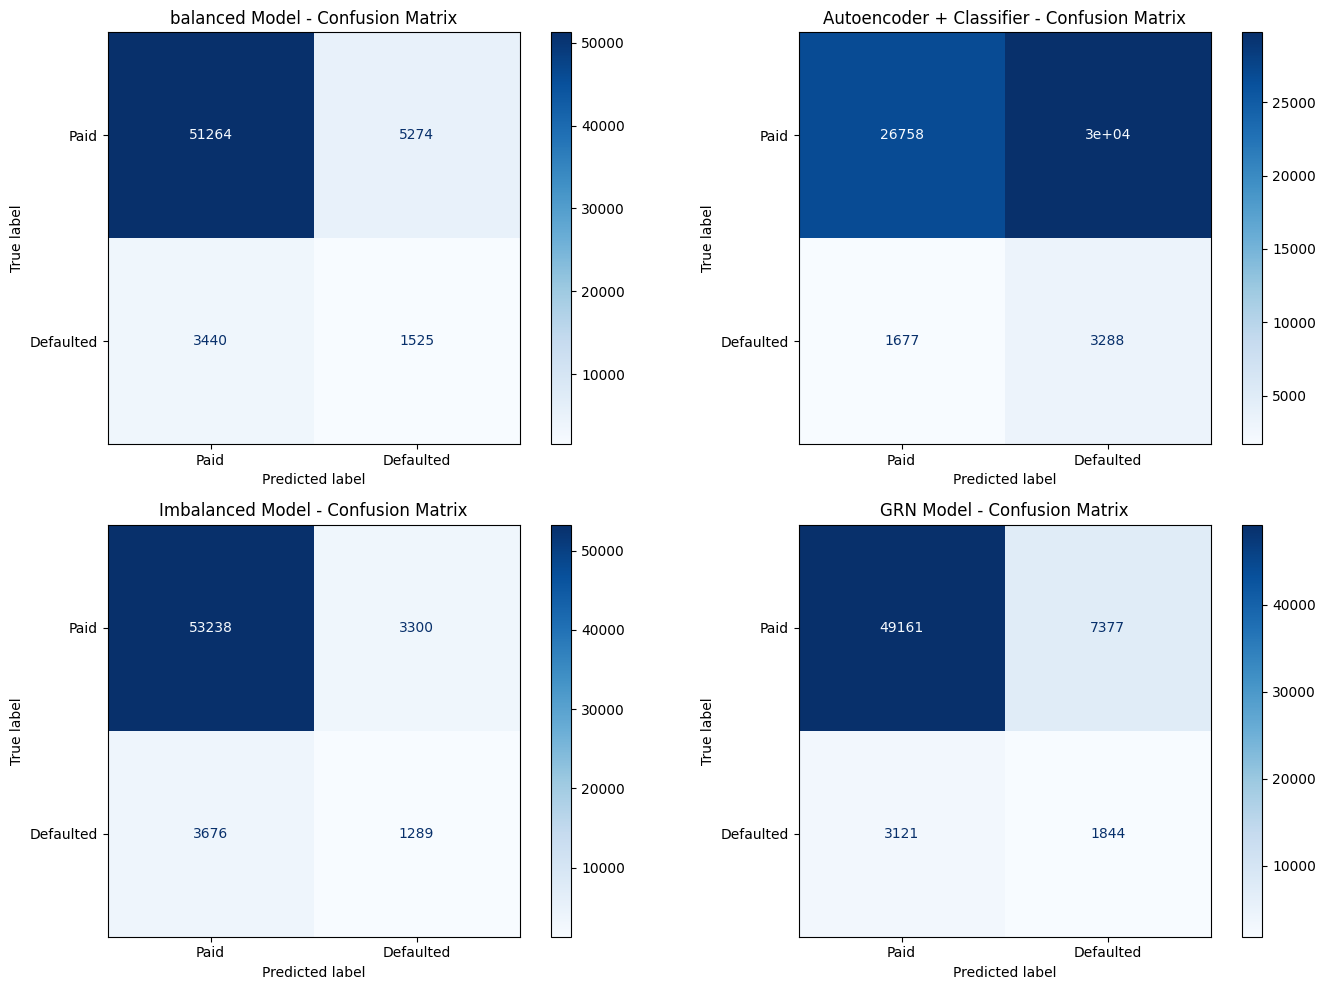

In [ ]:
plot_all_confusion_matrices(models, X_test, y_test, X_test_encoded=X_test_encoded)

### Autoencoder+Classifier:
Highest recall: great if your goal is to catch all defaulters.
Precision is too low for production without additional filtering.

### Imbalanced Model
Best precision, great if you want to minimize false positives.
Misses the majority of actual defaulters.

### Balanced Model / GRN
Strong overall performance with balanced recall & precision.
Ideal for a general-purpose.

1922/1922 ━━━━━━━━━━━━━━━━━━━━ 1s 352us/step
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 1s 448us/step


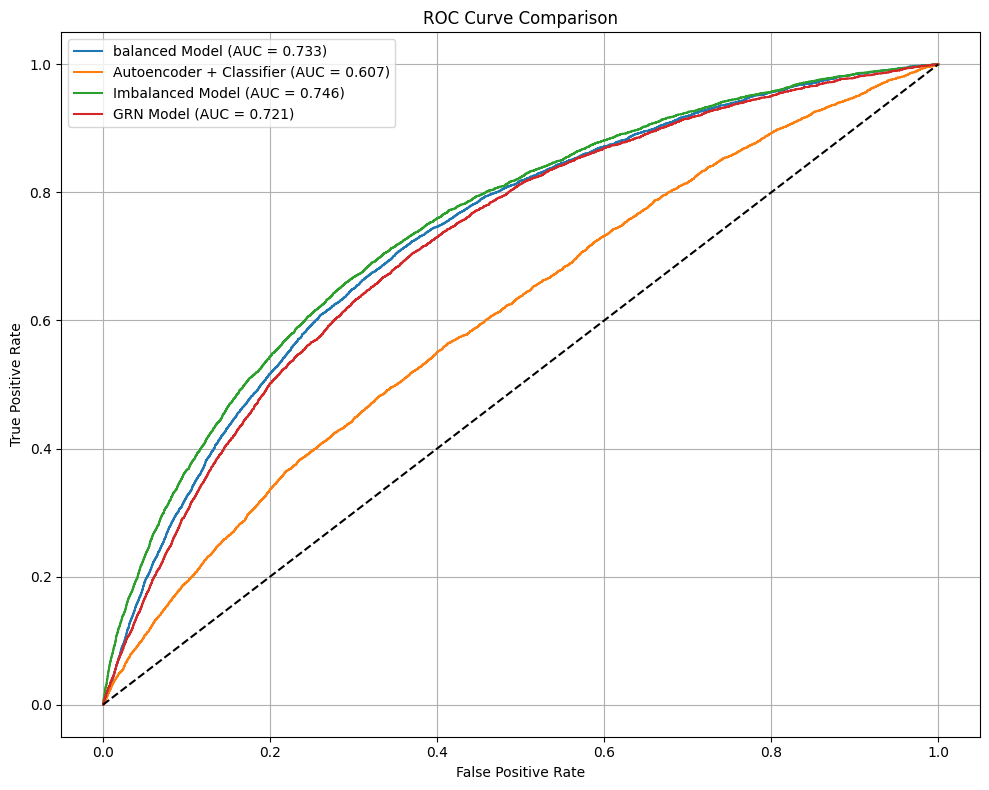

In [ ]:
plot_all_roc_curves(models, X_test, y_test, X_test_encoded=X_test_encoded)

### Imbalanced Model (AUC 0.746)
Despite missing some defaulters, it ranks samples better than any other model.
Shows the best separation between positive and negative classes.

### Balanced & GRN Models (AUC 0.721, 0.733)
Close performance
Strong candidates for production if balanced recall & precision are desired.

### Autoencoder + Classifier (AUC 0.607)
Performs the weakest in terms of true rank separation.
Despite high recall in earlier confusion matrix, it likely makes many high-confidence incorrect predictions.

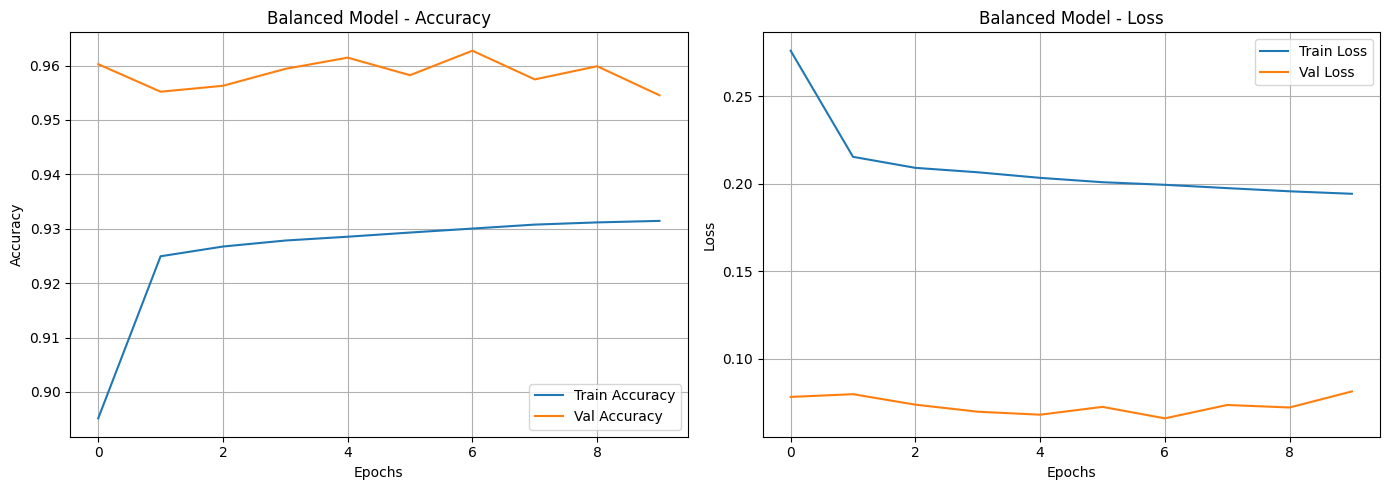

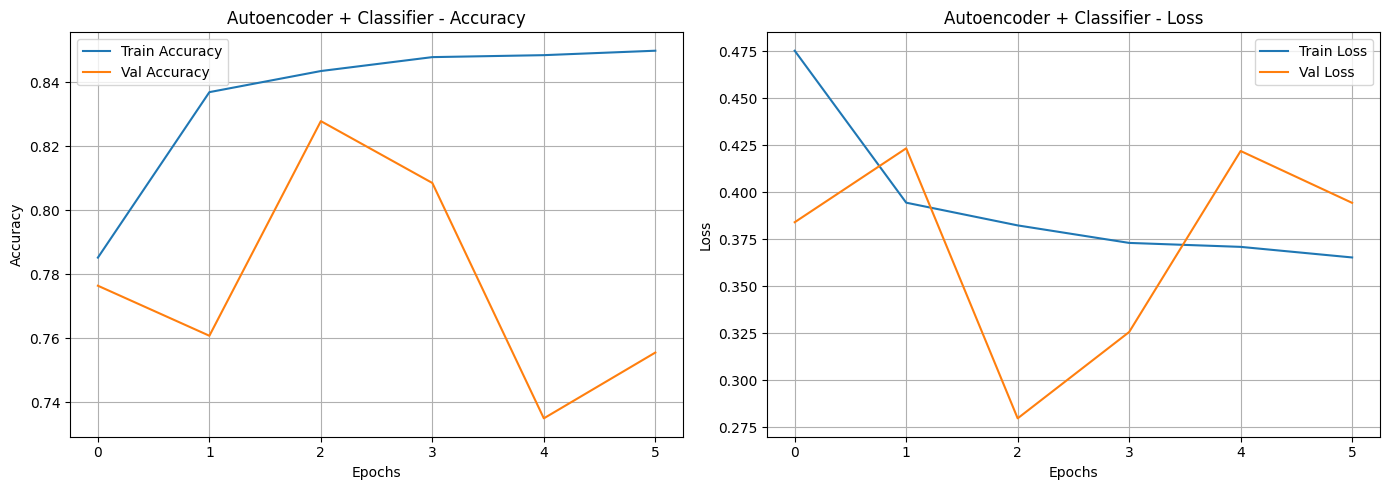

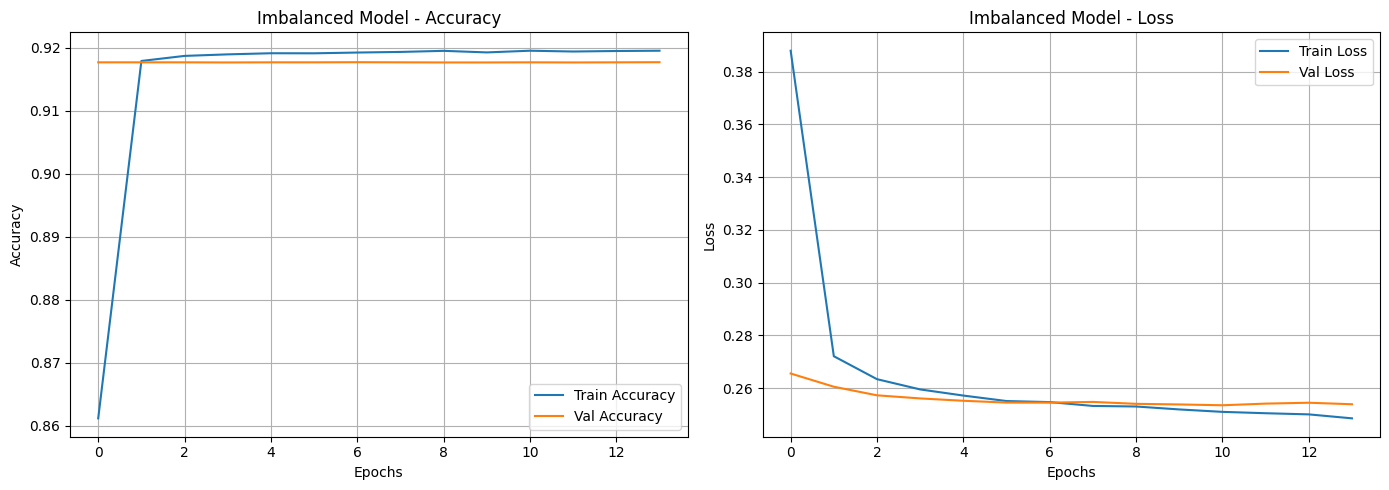

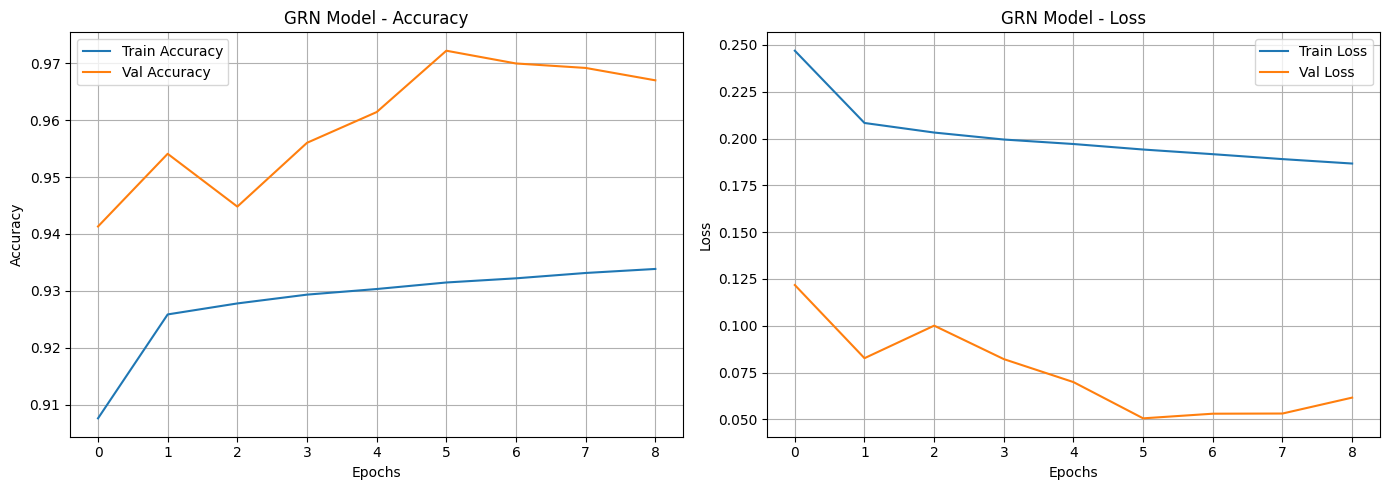

In [ ]:
def plot_history(history, title='Model'):
    plt.figure(figsize=(14, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example:
plot_history(history_balanced, 'Balanced Model')
plot_history(history_autoencoder, 'Autoencoder + Classifier')
plot_history(history_imbalanced, 'Imbalanced Model')
plot_history(history_grn, 'GRN Model')


### Balanced Model:

Train Accuracy stabilizes around 0.93.
Train loss steadily declines.
Validation loss is very low and flat — indicating possible underfitting or early stopping being too aggressive.
Stable and well-behaved. Possibly slightly underfitted, but very generalizable.

### Autoencoder Model:

Train accuracy steadily increases (0.78-0.84).
Validation accuracy is unstable and oscillates — no consistent improvement(overfitting warning).
Train loss drops, but validation loss fluctuates, indicating model instability or that it’s struggling to generalize.
Some learning, but highly unstable. Likely overfitting or struggling with noisy latent features.

### Imbalanced Model:

Train and Val accuracy match perfectly after just 1–2 epochs. Suspiciously “too good.”
Steep loss drop at the beginning, then steadily decrease.
Flat curve may indicate early convergence, but with limited generalization for minority class (defaults).
Likely biased toward majority class. Fast convergence, but limited learning from minority class.

### GRN Model:

Train accuracy improves steadily (0.91-0.94).
Validation accuracy improves sharply and even outpaces training accuracy (up to ~0.98). This could reflect: Highly regularized encoder, Stochastic noise in train batches
Validation loss is exceptionally low (~0.03) and decreasing.
Training loss slowly declines — model is still learning.
Strong learning behavior. May be slightly underfitting train data, but validating perfectly. Very promising for production if split integrity is confirmed.

